In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))

from src.utils.option_metrics import OptionMetricsFetcher
from src.engine.rbergomi import RBergomiEngine
from src.engine.calibrator import RBergomiCalibrator
from src.pricing.pricer import MonteCarloPricer

def extract_xi_variance_swap(df_slice):
    S0 = df_slice["stock_price"].iloc[0]
    T = df_slice["years_to_maturity"].iloc[0]
    r = df_slice["risk_free_rate"].iloc[0]
    df = df_slice.sort_values('strike').copy()
    F = S0 * np.exp(r * T)
    
    df['price'] = (df['best_bid'] + df['best_offer']) / 2
    
    
    term_list = []
    strikes = df['strike'].values
    prices = df['mid_price'].values
    
    for i in range(1, len(strikes)-1):
        dK = (strikes[i+1] - strikes[i-1]) / 2.0
        K = strikes[i]
        Q = prices[i]
        
        contribution = (dK / (K**2)) * np.exp(r*T) * Q
        term_list.append(contribution)
        
    sigma_squared = (2 / T) * sum(term_list)
    
    return sigma_squared

def extract_xi_atm(df_slice):
    S0 = df_slice["stock_price"].iloc[0]
    T = df_slice["years_to_maturity"].iloc[0]
    r = df_slice["risk_free_rate"].iloc[0]
    F = S0 * np.exp(r * T)
    
    df_slice = df_slice.copy()
    df_slice['dist_to_forward'] = abs(df_slice['strike'] - F)
    
    atm_option = df_slice.sort_values('dist_to_forward').iloc[0]
    
    sigma_atm = atm_option['impl_volatility']
    
    if pd.isna(sigma_atm) or sigma_atm <= 0:
        raise ValueError(f"Volatilité ATM invalide pour Strike={atm_option['strike']}: {sigma_atm}")

    xi_estime = sigma_atm ** 2
    
    info = {"xi_estime" : xi_estime,
        'forward_price': F,
        'atm_strike_found': atm_option['strike'],
        'atm_vol': sigma_atm,
        'distance_rel': atm_option['dist_to_forward'] / F, 
        'cp_flag': atm_option['cp_flag']
    }
    
    return xi_estime, info

om = OptionMetricsFetcher()

TICKER = 'SPX'
START = '2025-01-01'
END = '2025-01-31'

df_result = om.fetch_data(TICKER, START, END)

In [ ]:
from src.utils.cleaning import clean_and_filter_options, get_calibration_snapshot
df_clean = clean_and_filter_options(df_result)

calib_slice, T_exact, S0, r = get_calibration_snapshot(df_clean, '2025-01-03', 3/12)

print(f"\n--- (S0={S0}, T={T_exact:.4f}) ---")
calib_slice.sort_values("moneyness", ascending=False, inplace=True)
calib_slice


--- (S0=5942.47, T=1.9562) ---


,date,exdate,stock_price,strike,cp_flag,moneyness,mid_price,best_bid,best_offer,risk_free_rate,impl_volatility,delta,gamma,vega,theta,days_to_maturity,years_to_maturity,volume,open_interest
32711,2025-01-03,2026-12-18,5942.47,5000.0,P,1.188494,178.2,176.7,179.7,0.045443,0.21239,-0.164382,0.000139,2042.562,-68.28472,714,1.956164,7.0,55079.0
32718,2025-01-03,2026-12-18,5942.47,5350.0,P,1.110742,238.2,236.5,239.9,0.045443,0.198845,-0.217487,0.000177,2422.817,-66.63354,714,1.956164,75.0,676.0
32719,2025-01-03,2026-12-18,5942.47,5400.0,P,1.100457,247.95,246.2,249.7,0.045443,0.196898,-0.226028,0.000182,2476.147,-65.87015,714,1.956164,150.0,2017.0
32724,2025-01-03,2026-12-18,5942.47,5650.0,P,1.051765,301.9,300.0,303.8,0.045443,0.187185,-0.272691,0.000212,2732.607,-59.71149,714,1.956164,18.0,153.0
32725,2025-01-03,2026-12-18,5942.47,5700.0,P,1.042539,313.75,311.8,315.7,0.045443,0.185225,-0.282835,0.000218,2780.908,-57.95344,714,1.956164,18.0,1644.0
32726,2025-01-03,2026-12-18,5942.47,5750.0,P,1.033473,325.95,324.0,327.9,0.045443,0.183249,-0.293255,0.000224,2827.868,-55.99831,714,1.956164,136.0,442.0
32727,2025-01-03,2026-12-18,5942.47,5800.0,P,1.024564,338.5,336.5,340.5,0.045443,0.181254,-0.303957,0.00023,2873.337,-53.83706,714,1.956164,275.0,2514.0
32728,2025-01-03,2026-12-18,5942.47,5850.0,P,1.015807,351.45,349.4,353.5,0.045443,0.179253,-0.314951,0.000236,2917.188,-51.47076,714,1.956164,42.0,500.0
32647,2025-01-03,2026-12-18,5942.47,7200.0,C,0.825343,169.0,167.0,171.0,0.045443,0.130589,0.275293,0.000305,2745.243,-142.1205,714,1.956164,100.0,2380.0
32653,2025-01-03,2026-12-18,5942.47,7700.0,C,0.771749,68.95,67.8,70.1,0.045443,0.119923,0.144359,0.000227,1875.35,-84.8664,714,1.956164,68.0,113.0


In [ ]:
# xi_estime, info = extract_xi_atm(calib_slice)
# info
xi_estime = extract_xi_variance_swap(calib_slice) +0.002
xi_estime

np.float64(0.02086920624381805)

In [ ]:
engine = RBergomiEngine(
    S_0=S0,
    T=T_exact,
    N=500,
    r=r,
    xi_0=xi_estime,
    H=0.07,
    rho=-0.7,
    eta=1.9  
)

pricer = MonteCarloPricer(engine)

In [ ]:
calib_data_dict = {
    'market_strike': calib_slice['strike'],
    'ivs': calib_slice['impl_volatility'],
    'option_type': calib_slice['cp_flag']
}

turbo_calibrator = RBergomiCalibrator(engine, pricer, calib_data_dict, n_paths=2000)

initial_guess = [-0.6, 1.9]

print("Starting Calibration with L-BFGS-B...")
opt_params = turbo_calibrator.calibrate(initial_guess=initial_guess)

if opt_params is not None:
    rho_opt, eta_opt = opt_params
    print(f"\n RESULTS :")
    print(f"Rho (Skew) : {rho_opt:.4f}")
    print(f"Eta (Vol-of-Vol) : {eta_opt:.4f}")
    print(f"Xi (Fixed) : {xi_estime:.6f}")
else:
    print("Calibration Failed.")

Calibrator initialized with 13 options (3 Calls, 10 Puts).
Starting Calibration with L-BFGS-B...
Starting calibration (n_paths=2000)...
 >> Step: rho=-0.6000 | eta=1.9000 | RMSE=0.02813
 >> Step: rho=-0.6000 | eta=1.9000 | RMSE=0.02813
 >> Step: rho=-0.6000 | eta=1.9000 | RMSE=0.02813
 >> Step: rho=-0.6117 | eta=1.8950 | RMSE=0.02797
 >> Step: rho=-0.6117 | eta=1.8950 | RMSE=0.02797
 >> Step: rho=-0.6117 | eta=1.8950 | RMSE=0.02797
 >> Step: rho=-0.9854 | eta=1.5505 | RMSE=0.02498
 >> Step: rho=-0.9854 | eta=1.5505 | RMSE=0.02498
 >> Step: rho=-0.9854 | eta=1.5505 | RMSE=0.02498
 >> Step: rho=-0.9881 | eta=1.3649 | RMSE=0.02380
 >> Step: rho=-0.9881 | eta=1.3649 | RMSE=0.02380
 >> Step: rho=-0.9881 | eta=1.3649 | RMSE=0.02380
 >> Step: rho=-0.9900 | eta=0.6029 | RMSE=0.02730
 >> Step: rho=-0.9900 | eta=0.6029 | RMSE=0.02730
 >> Step: rho=-0.9900 | eta=0.6029 | RMSE=0.02730
 >> Step: rho=-0.9886 | eta=1.1719 | RMSE=0.02328
 >> Step: rho=-0.9886 | eta=1.1719 | RMSE=0.02328
 >> Step: rho=

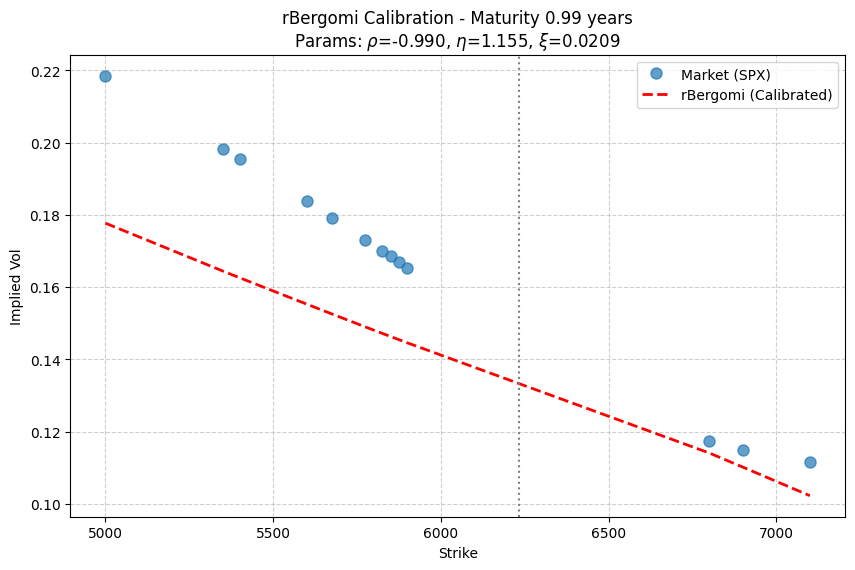

In [ ]:
final_ivs_model = []

strikes = calib_slice['strike'].values
types = calib_slice['cp_flag'].values
mkt_ivs = calib_slice['impl_volatility'].values

model_ivs_res = np.zeros_like(mkt_ivs)

mask_c = (types == 'call') | (types == 'C')
if np.any(mask_c):
    _, _, ivs_c = pricer.price_european_option_turbo(
        K=strikes[mask_c], n_paths=5000, option_type='call', return_iv=True 
    )
    model_ivs_res[mask_c] = ivs_c

mask_p = (types == 'put') | (types == 'P')
if np.any(mask_p):
    _, _, ivs_p = pricer.price_european_option_turbo(
        K=strikes[mask_p], n_paths=5000, option_type='put', return_iv=True
    )
    model_ivs_res[mask_p] = ivs_p

# --- PLOT ---
plt.figure(figsize=(10, 6))
plt.plot(strikes, mkt_ivs, 'o', label='Market (SPX)', markersize=8, alpha=0.7)
plt.plot(strikes, model_ivs_res, '--', label=f'rBergomi (Calibrated)', linewidth=2, color='red')

plt.title(f"rBergomi Calibration - Maturity {T_exact:.2f} years\n"
          f"Params: $\\rho$={rho_opt:.3f}, $\\eta$={eta_opt:.3f}, $\\xi$={xi_estime:.4f}")
plt.xlabel("Strike")
plt.ylabel("Implied Vol")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.axvline(x=S0 * np.exp(r * T_exact), color='gray', linestyle=':', label='Forward Price')

plt.show()
